In [ ]:
!pip install pandas numpy scikit-learn nltk transformers datasets beautifulsoup4 seaborn matplotlib wordcloud xgboost lxml
!pip uninstall -y torch torchvision torchaudio transformers
!pip install torch torchvision torchaudio transformers --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

nltk.download("stopwords")
from nltk.corpus import stopwords

dataset = load_dataset("reubenjohn/stackoverflow-unified-text-open-status-classification-sample")
df = dataset["train"].to_pandas()
df = df.sample(frac=0.1, random_state=42)  # Take 10% sample for speed
print(df.shape)
print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

(…)-00000-of-00001-bfb7472d661aa1cb.parquet:   0%|          | 0.00/116M [00:00<?, ?B/s]

(…)-00000-of-00001-7ca4f8923f32b3e0.parquet:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/112217 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22443 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/22443 [00:00<?, ? examples/s]

(11222, 17)
        PostId     PostCreationDate  OwnerUserId    OwnerCreationDate  \
2259   5470060  03/29/2011 08:55:40       681707  03/29/2011 08:55:40   
87003  9110783  02/02/2012 10:32:10      1129344  01/04/2012 06:43:09   
53317  6510288  06/28/2011 17:00:01        28565  10/16/2008 13:02:00   
71748  7586450  09/28/2011 16:29:06       969503  09/28/2011 16:22:42   
27031  2935137  05/29/2010 12:58:39       270875  02/11/2010 06:45:14   

       ReputationAtPostCreation  OwnerUndeletedAnswerCountAtPostTime  \
2259                          1                                    0   
87003                        18                                    2   
53317                       654                                    9   
71748                         1                                    0   
27031                        43                                    0   

                                                   Title  \
2259   How do you get info from a MySql database, to ...

In [ ]:
dataset = load_dataset("reubenjohn/stackoverflow-unified-text-open-status-classification-sample")
df = dataset["train"].to_pandas()
df = df.sample(frac=0.1, random_state=42)  # Take 10% sample for speed
print(df.shape)
print(df.head())


(11222, 17)
        PostId     PostCreationDate  OwnerUserId    OwnerCreationDate  \
2259   5470060  03/29/2011 08:55:40       681707  03/29/2011 08:55:40   
87003  9110783  02/02/2012 10:32:10      1129344  01/04/2012 06:43:09   
53317  6510288  06/28/2011 17:00:01        28565  10/16/2008 13:02:00   
71748  7586450  09/28/2011 16:29:06       969503  09/28/2011 16:22:42   
27031  2935137  05/29/2010 12:58:39       270875  02/11/2010 06:45:14   

       ReputationAtPostCreation  OwnerUndeletedAnswerCountAtPostTime  \
2259                          1                                    0   
87003                        18                                    2   
53317                       654                                    9   
71748                         1                                    0   
27031                        43                                    0   

                                                   Title  \
2259   How do you get info from a MySql database, to ...

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def clean_text(text):
    """Remove HTML tags, convert to lowercase, and remove special characters."""
    if not isinstance(text, str):
        return ""

    text = BeautifulSoup(text, "lxml").get_text()  # Use lxml to parse XML/HTML
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)  # Remove special characters
    return text.strip()

# Apply text cleaning
df["unified_texts"] = (df["Title"].fillna("") + " " + df["BodyMarkdown"].fillna("")).apply(clean_text)

# Map OpenStatus to numerical values
df["OpenStatus_id"] = df["OpenStatus"].factorize()[0]

print(df.head())


        PostId     PostCreationDate  OwnerUserId    OwnerCreationDate  \
2259   5470060  03/29/2011 08:55:40       681707  03/29/2011 08:55:40   
87003  9110783  02/02/2012 10:32:10      1129344  01/04/2012 06:43:09   
53317  6510288  06/28/2011 17:00:01        28565  10/16/2008 13:02:00   
71748  7586450  09/28/2011 16:29:06       969503  09/28/2011 16:22:42   
27031  2935137  05/29/2010 12:58:39       270875  02/11/2010 06:45:14   

       ReputationAtPostCreation  OwnerUndeletedAnswerCountAtPostTime  \
2259                          1                                    0   
87003                        18                                    2   
53317                       654                                    9   
71748                         1                                    0   
27031                        43                                    0   

                                                   Title  \
2259   How do you get info from a MySql database, to ...   
87003   

<ipython-input-5-68925f44fee7>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], x=df["OpenStatus"], palette="coolwarm", order=df["OpenStatus"].value_counts().index)
<ipython-input-5-68925f44fee7>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], x="OpenStatus", y="word_count", data=df, palette="coolwarm")
<ipython-input-5-68925f44fee7>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 1], x="OpenStatus", y="char_count", data=df, palette="coolwarm")


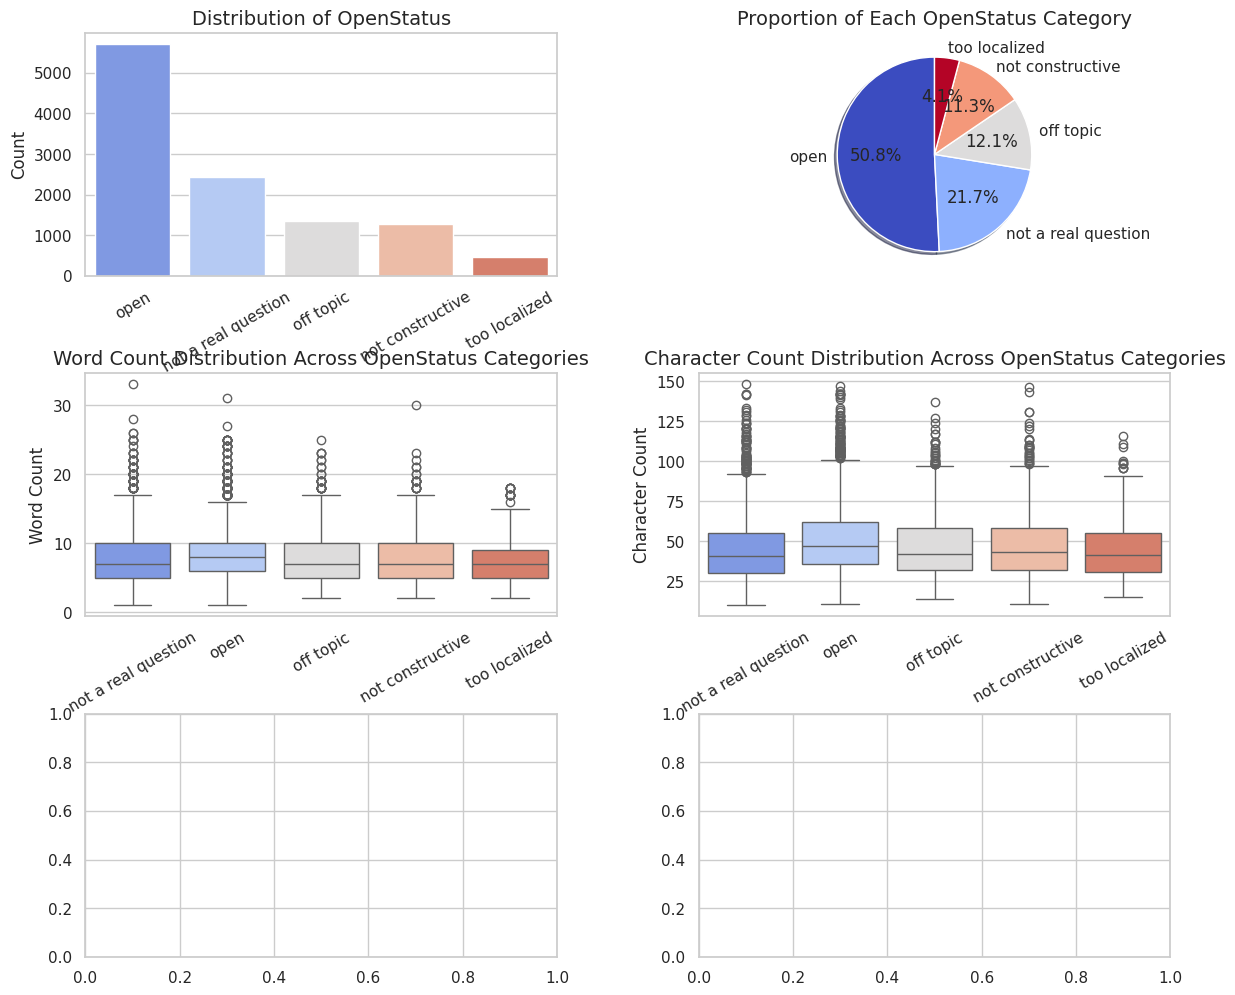

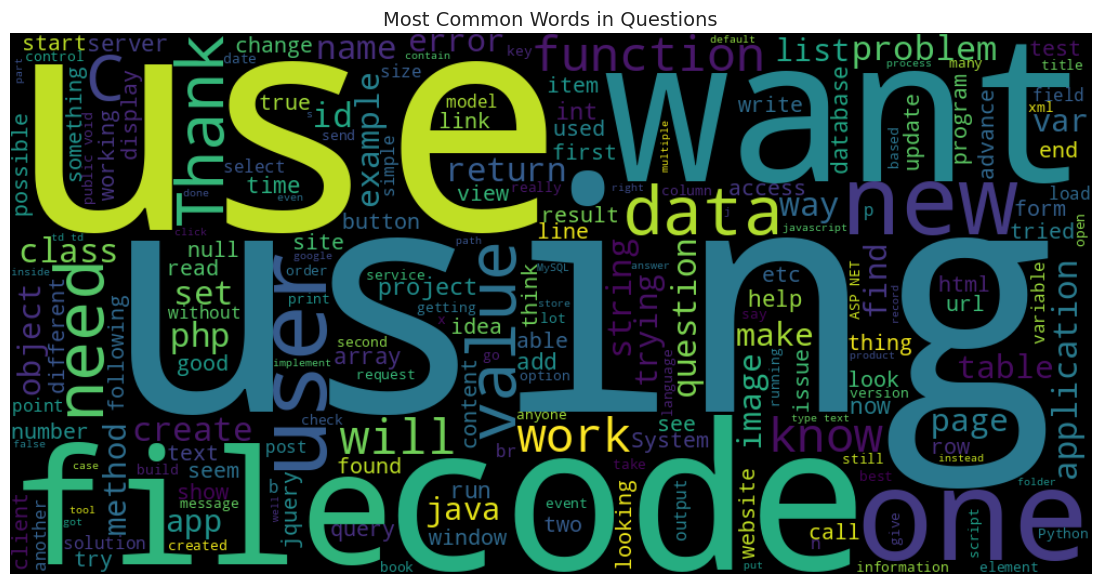

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set style
sns.set(style="whitegrid")

# Create a 3-row, 2-column layout
fig, axes = plt.subplots(3, 2, figsize=(14, 12))  # Increase figure size for better spacing

# Adjust spacing between plots (hspace: vertical space, wspace: horizontal space)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# --- 1. Distribution of OpenStatus ---
sns.countplot(ax=axes[0, 0], x=df["OpenStatus"], palette="coolwarm", order=df["OpenStatus"].value_counts().index)
axes[0, 0].set_title("Distribution of OpenStatus", fontsize=14)
axes[0, 0].set_xlabel("OpenStatus", fontsize=12)
axes[0, 0].set_ylabel("Count", fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=30)

# --- 2. Pie Chart for Class Distribution ---
df["OpenStatus"].value_counts().plot.pie(
    ax=axes[0, 1], autopct="%1.1f%%", cmap="coolwarm", startangle=90, shadow=True
)
axes[0, 1].set_title("Proportion of Each OpenStatus Category", fontsize=14)
axes[0, 1].set_ylabel("")  # Hide y-axis label

# --- 3. Word Count Distribution ---
df["word_count"] = df["Title"].apply(lambda x: len(str(x).split()))
sns.boxplot(ax=axes[1, 0], x="OpenStatus", y="word_count", data=df, palette="coolwarm")
axes[1, 0].set_title("Word Count Distribution Across OpenStatus Categories", fontsize=14)
axes[1, 0].set_xlabel("OpenStatus", fontsize=12)
axes[1, 0].set_ylabel("Word Count", fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=30)

# --- 4. Character Count Distribution ---
df["char_count"] = df["Title"].apply(lambda x: len(str(x)))
sns.boxplot(ax=axes[1, 1], x="OpenStatus", y="char_count", data=df, palette="coolwarm")
axes[1, 1].set_title("Character Count Distribution Across OpenStatus Categories", fontsize=14)
axes[1, 1].set_xlabel("OpenStatus", fontsize=12)
axes[1, 1].set_ylabel("Character Count", fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=30)

# --- 5. Word Cloud (Plotted Separately) ---
text = " ".join(df["Title"].astype(str) + " " + df["BodyMarkdown"].astype(str))
wordcloud = WordCloud(width=1000, height=500, background_color="black", colormap="viridis").generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Questions", fontsize=14)

# Final layout adjustment
plt.tight_layout()
plt.show()


In [ ]:
# Extract train, test, and validation sets
train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()
valid_df = dataset["valid"].to_pandas()

# Function to preprocess text
def clean_text(text):
    """Remove HTML tags, convert to lowercase, and remove special characters."""
    if not isinstance(text, str):
        return ""

    text = BeautifulSoup(text, "lxml").get_text()  # Use lxml to parse XML/HTML
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)  # Remove special characters
    return text.strip()

# Apply text cleaning
train_df["unified_texts"] = (train_df["Title"].fillna("") + " " + train_df["BodyMarkdown"].fillna("")).apply(clean_text)
test_df["unified_texts"] = (test_df["Title"].fillna("") + " " + test_df["BodyMarkdown"].fillna("")).apply(clean_text)
valid_df["unified_texts"] = (valid_df["Title"].fillna("") + " " + valid_df["BodyMarkdown"].fillna("")).apply(clean_text)

# Convert OpenStatus to numerical values
train_df["OpenStatus_id"] = train_df["OpenStatus"].factorize()[0]
test_df["OpenStatus_id"] = test_df["OpenStatus"].map(train_df[["OpenStatus", "OpenStatus_id"]].drop_duplicates().set_index("OpenStatus")["OpenStatus_id"])
valid_df["OpenStatus_id"] = valid_df["OpenStatus"].map(train_df[["OpenStatus", "OpenStatus_id"]].drop_duplicates().set_index("OpenStatus")["OpenStatus_id"])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["unified_texts"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["unified_texts"])
X_valid_tfidf = tfidf_vectorizer.transform(valid_df["unified_texts"])

# Metadata Features
train_meta = train_df[["ReputationAtPostCreation", "OwnerUndeletedAnswerCountAtPostTime"]].fillna(0)
test_meta = test_df[["ReputationAtPostCreation", "OwnerUndeletedAnswerCountAtPostTime"]].fillna(0)
valid_meta = valid_df[["ReputationAtPostCreation", "OwnerUndeletedAnswerCountAtPostTime"]].fillna(0)

# Combine Features
X_train = np.hstack((X_train_tfidf.toarray(), train_meta.to_numpy()))
X_test = np.hstack((X_test_tfidf.toarray(), test_meta.to_numpy()))
X_valid = np.hstack((X_valid_tfidf.toarray(), valid_meta.to_numpy()))
y_train = train_df["OpenStatus_id"]
y_test = test_df["OpenStatus_id"]
y_valid = valid_df["OpenStatus_id"]



XGBoost Test Accuracy: 0.55438221271666
              precision    recall  f1-score   support

           0       0.56      0.94      0.70     11176
           1       0.33      0.00      0.00      1009
           2       0.49      0.26      0.34      4949
           3       0.62      0.04      0.07      2788
           4       0.60      0.21      0.31      2521

    accuracy                           0.55     22443
   macro avg       0.52      0.29      0.29     22443
weighted avg       0.55      0.55      0.47     22443



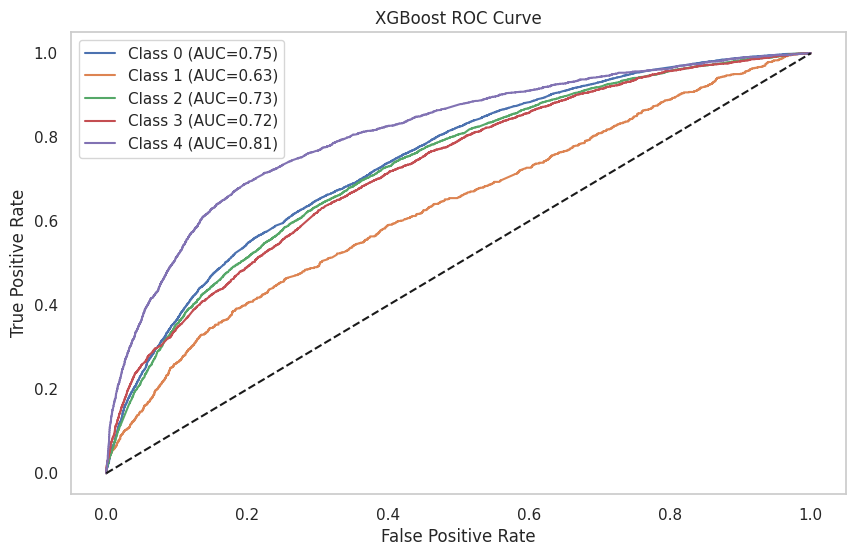

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert NumPy arrays to Pandas for sampling
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train)

# Sample only 10% of the data for faster training
X_train_small = X_train_df.sample(frac=0.1, random_state=42).values  # Convert back to NumPy
y_train_small = y_train_df.sample(frac=0.1, random_state=42).values  # Convert back to NumPy

# Binarize the target labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Initialize XGBoost Classifier with optimized parameters
xgb_clf = XGBClassifier(n_estimators=50, learning_rate=0.05, max_depth=3, verbosity=1)

# Train XGBoost only once (no loop!)
xgb_clf.fit(X_train_small, y_train_small, eval_set=[(X_test, y_test)], verbose=False)

# Predict on Test Data
y_pred_xgb_test = xgb_clf.predict(X_test)
y_pred_xgb_proba = xgb_clf.predict_proba(X_test)  # Probabilities for ROC-AUC

# Evaluate Model
print("\nXGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb_test))
print(classification_report(y_test, y_pred_xgb_test))

# ------------------- Plot ROC Curve -------------------
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_xgb_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize Text
def tokenize_function(example):
    return tokenizer(example["unified_texts"], truncation=True, padding="max_length")

dataset = dataset.map(tokenize_function, batched=True)

# Load BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(df["OpenStatus_id"].unique()))

# Training Arguments
training_args = TrainingArguments(output_dir="./results", evaluation_strategy="epoch")

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

# Train BERT Model
trainer.train()


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.743808
2,No log,0.804069
3,No log,0.822841


TrainOutput(global_step=3, training_loss=0.706131378809611, metrics={'train_runtime': 44.038, 'train_samples_per_second': 0.204, 'train_steps_per_second': 0.068, 'total_flos': 2367999498240.0, 'train_loss': 0.706131378809611, 'epoch': 3.0})

In [ ]:
def predict_question_status(question_title, question_body):
    """Predicts the OpenStatus of a given Stack Overflow question."""
    text = clean_text(question_title + " " + question_body)

    # Convert text to TF-IDF vector
    text_tfidf = tfidf_vectorizer.transform([text])

    # Use average metadata values
    avg_metadata = np.array([[1000, 1]])
    text_combined = np.hstack((text_tfidf.toarray(), avg_metadata))

    # Predict using best model (XGBoost)
    predicted_status = xgb_clf.predict(text_combined)[0]

    # if predicted_status == 0:
    #     predicted_status = "open"
    # elif predicted_status == 1:
    #     predicted_status = "not a real question"
    # elif predicted_status == 2:
    #     predicted_status = "off topic"
    # elif predicted_status == 3:
    #   predicted_status = "too localized"
    # elif predicted_status == 4:
    #   predicted_status = "not contructive"
    print(f"Predicted Status: {predicted_status}")

# Example Prediction
question_title = "how to change the general JAVA COFFEE CUP icon in JAR file"
question_body = "I can change the JAVA COFFEE CUP icon in my Frame (up,left), but how could I change the RUNNABLE JAR file's general JAVA COFFEE CUP picture? Is it possible at all, to change only one JAR file's file icon? Thx"
predict_question_status(question_title, question_body)


Predicted Status: 0
